# Imports

In [1]:
import pandas as pd
import os

from dotenv import load_dotenv

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from pandasai import clear_cache
from pandasai import Agent

# Initialization

In [2]:
READ_FROM_PICKLE = True

In [3]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [4]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("data/malicious_features_numeric.pkl")
    benign_df = pd.read_pickle("data/benign_features_numeric.pkl")

In [5]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)

In [6]:
malicious_smart = SmartDataframe(
    df=pd.DataFrame(malicious_df),
    config={"llm": llm, "verbose": True},
    name="Mirai botnet network packet capture.",
    description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.",
)

In [7]:
benign_smart = SmartDataframe(
    df=pd.DataFrame(benign_df),
    config={"llm": llm, "verbose": True},
    name="Packet capture of normal operation network travvid.",
    description="A dataframe that is derived from a packet capture of the regular operation of a network.",
)

In [8]:
malicious_smart.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Payload',
       'Packet Length', 'Protocol', 'src_ip_total_bytes', 'dst_ip_total_bytes',
       'Numeric Source IP', 'Numeric Destination IP', 'dst_port_freq_encoded',
       'Interarrival'],
      dtype='object')

# EDA

## Statistical

### Exploration via prompting

In [9]:
top_5_source_IPs = malicious_smart.chat("Which are the 5 most popular source IP addresses?")

top_5_source_IPs

2024-05-13 15:24:55 [INFO] Question: Which are the 5 most popular source IP addresses?
2024-05-13 15:24:55 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:24:55 [INFO] Prompt ID: bd8ccbce-a3a2-4c3d-ab80-60c9defb1f53
2024-05-13 15:24:55 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:24:55 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:24:55 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641897592316178,0.457746982574

,Numeric Source IP,Count
0,3232236140,51747
1,3232236145,34415
2,3232236142,16520
3,3232236147,13486
4,3232236144,9158


In [10]:
print(malicious_smart.last_code_generated)

source_ip_counts = dfs[0]['Numeric Source IP'].value_counts().head(5).reset_index()
source_ip_counts.columns = ['Numeric Source IP', 'Count']
result = {'type': 'dataframe', 'value': source_ip_counts}


In [11]:
top_5_dst_ports = malicious_smart.chat("Find the most used destination ports.")
top_5_dst_ports

2024-05-13 15:25:00 [INFO] Question: Find the most used destination ports.
2024-05-13 15:25:00 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:00 [INFO] Prompt ID: 716d6a2c-3c2d-42f9-bbc3-9db45653c883
2024-05-13 15:25:00 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:00 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:00 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641897592316178,0.4577469825744629
1993868

10240.0

In [12]:
print(malicious_smart.last_code_generated)

most_used_ports = dfs[0]['Destination Port'].value_counts().idxmax()
result = {'type': 'number', 'value': most_used_ports}


### Prompt engineering

In [13]:
rare_ports = malicious_smart.chat(
    "Which are the most rarely used destination ports within the range of 0-1024?"
)
rare_ports

2024-05-13 15:25:01 [INFO] Question: Which are the most rarely used destination ports within the range of 0-1024?
2024-05-13 15:25:01 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:01 [INFO] Prompt ID: 7fd1d425-45fa-406d-b292-54fa3702bb93
2024-05-13 15:25:01 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:01 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:01 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641

'The most rarely used destination ports within the range of 0-1024 are: 137.0'

In [14]:
rare_ports = malicious_smart.chat(
    "Which are the most rarely used destination ports less than or equal to 1024?"
)
rare_ports

2024-05-13 15:25:06 [INFO] Question: Which are the most rarely used destination ports less than or equal to 1024?
2024-05-13 15:25:06 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:06 [INFO] Prompt ID: b287f9bb-7200-4b2f-8f79-78ed5f1952aa
2024-05-13 15:25:06 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:06 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:06 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'columns'\n"

### Correlation

In [15]:
correlation = malicious_smart.chat(
    """1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    """
)
correlation

2024-05-13 15:25:12 [INFO] Question: 1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    
2024-05-13 15:25:12 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:12 [INFO] Prompt ID: c1b78e61-3ed6-4ae4-9c17-56215bd558d4
2024-05-13 15:25:12 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:12 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:12 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmart

'The correlation between the source port and the length of a packet is: -0.16566431740345833. The correlation is not significant.'

### Hypothesis testing

In [16]:
hypothesis = malicious_smart.chat(
    "Is the difference between dst_ip_total_bytes and Packet Length statistically significant?"
)
hypothesis

2024-05-13 15:25:16 [INFO] Question: Is the difference between dst_ip_total_bytes and Packet Length statistically significant?
2024-05-13 15:25:16 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:16 [INFO] Prompt ID: f826c3ef-c582-4d63-bdc9-658019e9747f
2024-05-13 15:25:16 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:16 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:16 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,32322

'The difference between dst_ip_total_bytes and Packet Length is statistically significant.'

### Outliers

In [17]:
outliers = malicious_smart.chat(
    "Find the z score of the Packet Length and then calculate the top ten outliers."
)
outliers

2024-05-13 15:25:22 [INFO] Question: Find the z score of the Packet Length and then calculate the top ten outliers.
2024-05-13 15:25:22 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:22 [INFO] Prompt ID: 2cf8397a-ae97-4cbe-a5d8-b454719bab8f
2024-05-13 15:25:22 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:22 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:22 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.216

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,Packet Length Z Score
581,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2000,311,3232236147,4026531834,0.006827,0.107952,6.874131
582,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2166,477,3232236147,4026531834,0.006827,0.000148,6.874131
583,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2332,643,3232236147,4026531834,0.006827,0.000002,6.874131
1012,1.540446e+09,67.0,68.0,BOOTP,166,17.0,1791,166,3232236033,4294967295,0.000883,0.034520,6.874131
1351,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5709,809,3232236147,4026531834,0.006827,0.083352,6.874131
1352,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5875,975,3232236147,4026531834,0.006827,0.007626,6.874131
1353,1.540446e+09,1215.0,1900.0,Raw,166,17.0,6041,1141,3232236147,4026531834,0.006827,0.000676,6.874131
2257,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9468,1597,3232236147,4026531834,0.006827,0.065097,6.874131
2258,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9634,1763,3232236147,4026531834,0.006827,0.001044,6.874131
2259,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9800,1929,3232236147,4026531834,0.006827,0.001050,6.874131


## Visualizations

2024-05-13 15:25:24 [INFO] Question: Plot the histogram of src_ip_total_bytes with purple color.
2024-05-13 15:25:24 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:24 [INFO] Prompt ID: f23db8c0-a146-4919-8419-40d51e772065
2024-05-13 15:25:24 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:24 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:24 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641897592316178,0.45

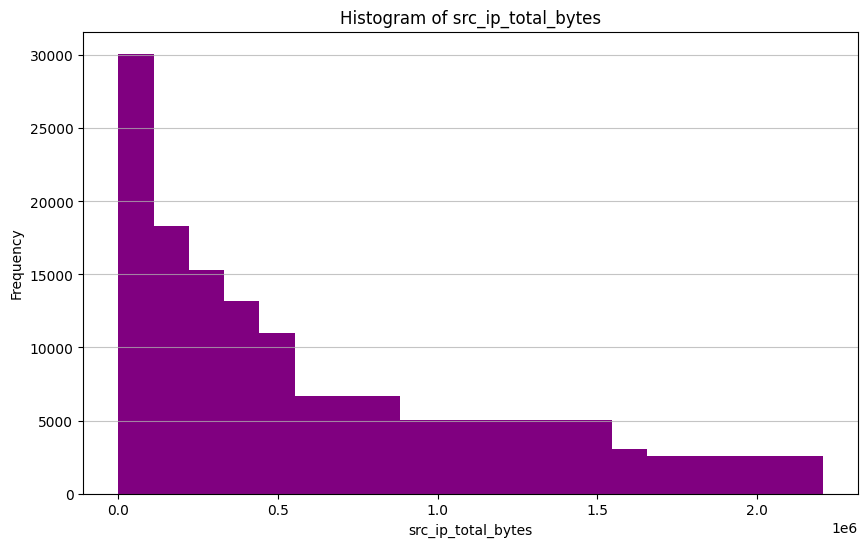

2024-05-13 15:25:28 [INFO] Executing Step 5: ResultValidation
2024-05-13 15:25:28 [INFO] Answer: {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}
2024-05-13 15:25:28 [INFO] Executed in: 3.8970720767974854s
2024-05-13 15:25:28 [INFO] Executing Step 6: ResultParsing


'/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'

In [18]:
malicious_smart.chat(
    "Plot the histogram of src_ip_total_bytes with purple color."
)

In [19]:
print(malicious_smart.last_code_executed)

df = dfs[0]
plt.figure(figsize=(10, 6))
plt.hist(df['src_ip_total_bytes'], color='purple', bins=20)
plt.title('Histogram of src_ip_total_bytes')
plt.xlabel('src_ip_total_bytes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
result = {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}


2024-05-13 15:25:28 [INFO] Question: Plot the histogram dst_port_freq_encoded.
2024-05-13 15:25:29 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:29 [INFO] Prompt ID: 5275f838-88e7-4f26-8e83-2d562ac6f47b
2024-05-13 15:25:29 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:29 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:29 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.21641897592316178,0.4577469825744629
199

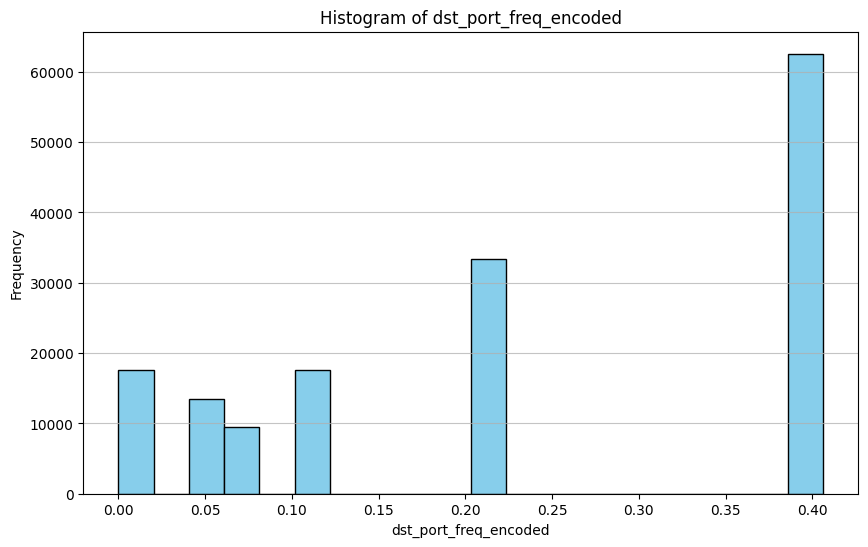

2024-05-13 15:25:32 [INFO] Executing Step 5: ResultValidation
2024-05-13 15:25:32 [INFO] Answer: {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}
2024-05-13 15:25:32 [INFO] Executed in: 3.494812250137329s
2024-05-13 15:25:32 [INFO] Executing Step 6: ResultParsing


'/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'

In [20]:
malicious_smart.chat("Plot the histogram dst_port_freq_encoded.")

In [21]:
print(malicious_smart.last_code_executed)

df = dfs[0]
plt.figure(figsize=(10, 6))
plt.hist(df['dst_port_freq_encoded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of dst_port_freq_encoded')
plt.xlabel('dst_port_freq_encoded')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
result = {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}


# Agents

In [22]:
from pandasai import Agent

In [23]:
agent = Agent(malicious_smart, config={"llm": llm},memory_size=1000)

In [24]:
agent.chat('Is this dataframe indicating malicious or benign network behavior?')

2024-05-13 15:25:32 [INFO] Question: Is this dataframe indicating malicious or benign network behavior?
2024-05-13 15:25:32 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:32 [INFO] Prompt ID: 5fd78110-b156-42ed-aa02-82cacc4f1406
2024-05-13 15:25:32 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:32 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:32 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6157472520,21074.0,80.0,Padding,26,6.0,26,26,4476837068,873999171,0.11450451035109352,
6405020828,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_W_724V_01011603_00_005.'"" ",83,17.0,83,83,7064011918,3232236033,0.216418975923161

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo code found in the response\n'

In [25]:
agent.chat('The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 443 for HTTPS and 22 for SSH. Is this packet capture malicious or benign?')

2024-05-13 15:25:37 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-13 15:25:37 [INFO] Check if the new message is related to the conversation: True
2024-05-13 15:25:37 [INFO] Question: The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 443 for HTTPS and 22 for SSH. Is this packet capture malicious or benign?
2024-05-13 15:25:37 [INFO] Running PandasAI with openai LLM...
2024-05-13 15:25:37 [INFO] Prompt ID: aa4aaa43-403f-4ab3-9353-3424e8c2fab9
2024-05-13 15:25:37 [INFO] Executing Step 0: CacheLookup
2024-05-13 15:25:37 [INFO] Executing Step 1: PromptGeneration
2024-05-13 15:25:37 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet

'The packet capture is indicating malicious network behavior.'

In [26]:
agent.explain()

2024-05-13 15:25:41 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-13 15:25:41 [INFO] Explanation:  I used a list of unusual ports and a threshold value to check for any malicious requests in the network traffic data. If there are more malicious requests than the threshold, the code will determine that the network behavior is malicious. Otherwise, it will conclude that the network behavior is benign.
                


'I used a list of unusual ports and a threshold value to check for any malicious requests in the network traffic data. If there are more malicious requests than the threshold, the code will determine that the network behavior is malicious. Otherwise, it will conclude that the network behavior is benign.'

# Clear cache

In [28]:
clear_cache()